In [1]:
import TurbPy as tb
from TurbPy.imports import *

In [2]:
# deck = 'KH_Lv1di/'
# deck = 'KH_new/'
# deck = 'KH_400ppc_200wci2/'
deck = 'KH_200ppc_200wci/'
# deck = 'KH_beta0.1/'
# deck = 'turb2/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx_de = info['Lx/de']
ly_de = info['Ly/de']

lx_di = info['Lx/di']
ly_di = info['Ly/di']

nx = int(info['nx'])
ny = int(info['ny'])

lxr_di = np.linspace(0, lx_di, nx)
lyr_di = np.linspace(0, ly_di, ny)

lxr_de = np.linspace(0, lx_de, nx)
lyr_de = np.linspace(0, ly_de, ny)

In [16]:
import numpy.fft as nf

def PerpSpectrum(ar,sumax=2,lenx=2*np.pi,leny=2*np.pi,lenz=2*np.pi):
   """
      PerpSpectrum(ar,sumax=2,lenx=2*pi,leny=2*pi,lenz=2*pi)
      ar -> Array to compute the spectrum of
      sumax -> Axis of magnetic field direction. Right now only x,y,z = 0,1,2
      lenx,leny,lenz -> System size in x,y,z directions to take into
                        account the anisotropy of system if any

      RETURNS:
      kk -> Wavenumber array
      fekp -> Spectrum of the array
   """
   if len(ar) == 0:
      print('No array provided! Exiting!')
      return
   ar=ar-np.mean(ar)
   nx=np.shape(ar)[0];kx=nf.fftshift(nf.fftfreq(nx))*nx*(2*np.pi/lenx)
   # print(nx)
   ny=np.shape(ar)[1];ky=nf.fftshift(nf.fftfreq(ny))*ny*(2*np.pi/leny)
   # print(ny)
   nz=np.shape(ar)[2];kz=nf.fftshift(nf.fftfreq(nz))*nz*(2*np.pi/lenz)
 
   far = nf.fftshift(nf.fftn(ar))/(nx*ny); fftea=0.5*np.abs(far)**2
   ffteb=np.sum(fftea,axis=sumax)
   # ffteb = fftea
## DEFINE A TEMPORARY XY PLANE
   if sumax==0:
      nnx=ny; nny=nz
      kkx=ky; kky=kz
   elif sumax==1:
      nnx=nx; nny=nz
      kkx=kx; kky=kz
   elif sumax==2:
      nnx=nx; nny=ny
      kkx=kx; kky=ky
## DEFINE THE KPERP VALUES AND CORRESPONDING SPECTRUM
   fekp=np.zeros(min(nnx//2,nny//2))
   kp=np.zeros((nnx,nny))
   for x in range(nnx):
      for y in range(nny):
         kp[x,y]=np.sqrt(kkx[x]**2+kky[y]**2)
   if nnx == 1:
      dk=np.abs(kp[0,1]-kp[0,0])
      kk=kp[0,nny//2:]
   elif nny == 1:
      dk=np.abs(kp[1,0]-kp[0,0])
      kk=kp[nnx//2:,0]
   else:
      dk=np.abs(kp[1,0]-kp[0,0])
      kk=kp[nnx//2,nny//2:]

   for i in range(len(fekp)):
      fekp[i]= np.sum(np.ma.MaskedArray(ffteb, ~((kp[nx//2,i+ny//2]-dk < kp) & (kp < kp[nx//2,i+ny//2]+dk))))
   #for x in range(nnx):
   #   for y in range(nny):
   #      i=np.round(kp[x,y]/dk)
   #      if i < len(fekp):
   #         fekp[i]=fekp[i]+ffteb[x,y]

   return kk,fekp/dk

In [21]:
def PerpSpecVec(arx,ary,arz,sumx=2,lx=2*np.pi,ly=2*np.pi,lz=2*np.pi):
   """
      PerpSpecVec(arx,ary,arz,sumx=2,lx=2*pi,ly=2*pi,lz=2*pi)
      arx,ary,arz -> Components of a vector to compute the spectrum of
      sumax -> Axis of magnetic field direction. Right now only x,y,z = 0,1,2
      lenx,leny,lenz -> System size in x,y,z directions to take into 
                        account the anisotropy of system if any

      RETURNS:
      kk -> Wavenumber array
      ekx,eky,ekz,ekx+eky+ekz -> Spectrum of the array
   """
   kwave,ekx = PerpSpectrum(arx,sumax=sumx,lenx=lx,leny=ly,lenz=lz)
   kwave,eky = PerpSpectrum(ary,sumax=sumx,lenx=lx,leny=ly,lenz=lz)
   kwave,ekz = PerpSpectrum(arz,sumax=sumx,lenx=lx,leny=ly,lenz=lz)
   return kwave,ekx,eky,ekz,ekx+eky+ekz

In [56]:
f=h5py.File(dirs + 'filter_hdf5/T.50000/ion_50000.h5','r')
jx=f['jx'][()];jy=f['jy'][()];jz=f['jz'][()];rho=f['rho'][()]
ux=jx/rho; uy=jy/rho; uz=jz/rho
f.close()

flip_ux = np.fliplr(ux)
flip_uy = np.fliplr(uy)
flip_uz = np.fliplr(uz)

Ux=np.zeros((2560,2560));Uy=np.zeros((2560,2560));Uz=np.zeros((2560,2560))
Ux[:1280,:2560]=ux;Uy[:1280,:2560]=uy;Uz[:1280,:2560]=uz
Ux[1280:,:2560]=flip_ux;Uy[1280:,:2560]=flip_uy;Uz[1280:,:2560]=flip_uz

Ux=Ux.reshape(2560,2560,1);Uy=Uy.reshape(2560,2560,1);Uz=Uz.reshape(2560,2560,1)

# ku_1,ukx_1,uky_1,ukz_1,Uktot_1 = PerpSpecVec(Ux,Uy,Uz,sumx=2,lx=2 * info['Lx/de'],ly=info['Ly/de'],lz=info['Lz/de'])

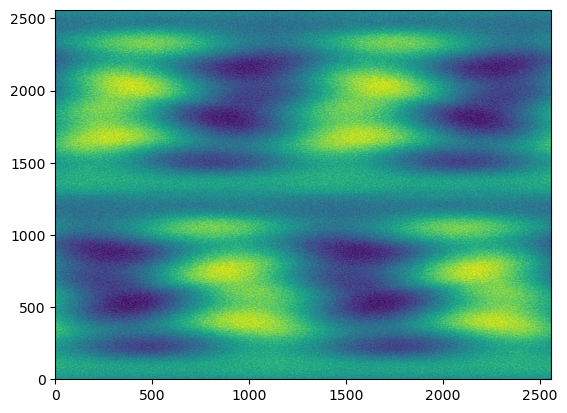

In [62]:
plt.pcolormesh(Ux[:,:,0])

In [ ]:
def flip2D(var):
  # var_flip = np.flip(var, axis = 0)
  var_flip = np.flip(var, axis = 0)
  var_per = np.concatenate((var, var_flip))
  return var_per

In [ ]:
def Euspec_prep(tin):
  t = times[tin]
  print(twci[tin])
  ds = tb.load_hydro_fil(dirs, t, 'ion')

  ux = ds['jx']/ds['rho']
  uy = ds['jy']/ds['rho']
  uz = ds['jz']/ds['rho']

  dux = ux - np.mean(ux)
  duy = uy - np.mean(uy)
  duz = uz - np.mean(uz)

  dux = flip2D(dux)
  duy = flip2D(duy)
  duz = flip2D(duz)
  # k, fft = tb.EuSpec2D(dux, duy, duz, lx = lx_de, ly = ly_de)
  k, fftx = PerpSpectrum(dux, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, ffty = PerpSpectrum(duy, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  k, fftz = PerpSpectrum(duz, lenx = 2 * info['Lx/de'], leny = info['Ly/de'])
  fft = fftx + ffty + fftz
  return k, fft

13.810680000000003
1.4997777122321454e-21


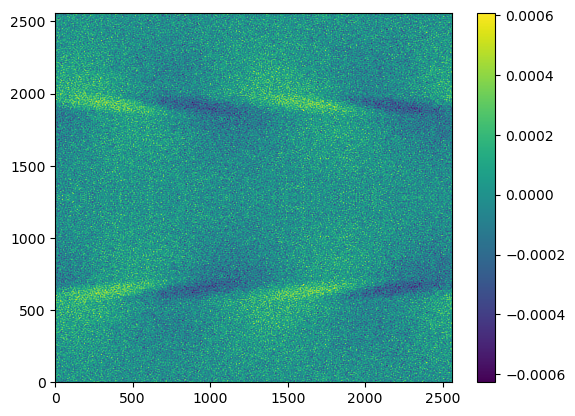

In [46]:
tin = 100
t = times[tin]
print(twci[tin])
ds = tb.load_hydro_fil(dirs, t, 'ion')

ux = ds['jx']/ds['rho']
uy = ds['jy']/ds['rho']
uz = ds['jz']/ds['rho']

dux = ux - np.mean(ux)
duy = uy - np.mean(uy)
duz = uz - np.mean(uz)

dux = flip2D(dux)
duy = flip2D(duy)
duz = flip2D(duz)
print(np.mean(duz))
plt.pcolormesh(duz)
plt.colorbar()

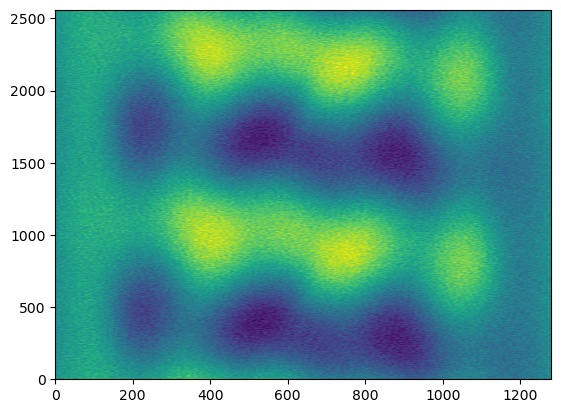

In [49]:
plt.pcolormesh(ux.T)

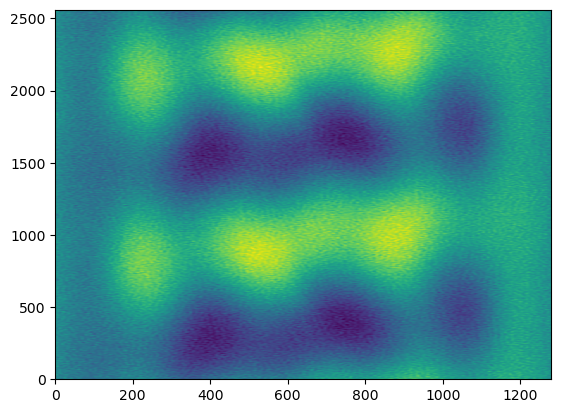

In [50]:
plt.pcolormesh(np.flip(ux, axis = 0).T)

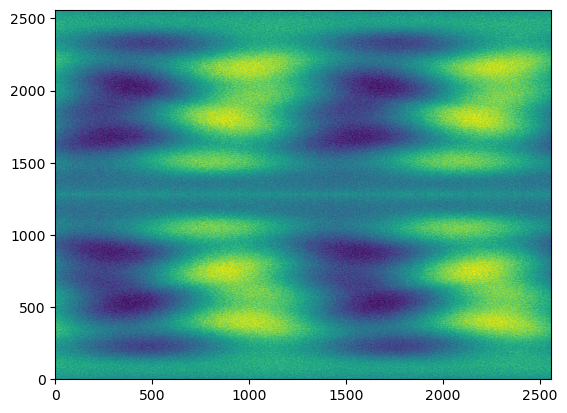

In [63]:
plt.pcolormesh(np.concatenate((ux, np.flip(ux, axis = 0))))

13.810680000000003
-9.999223942337015e-21


TypeError: cannot unpack non-iterable NoneType object

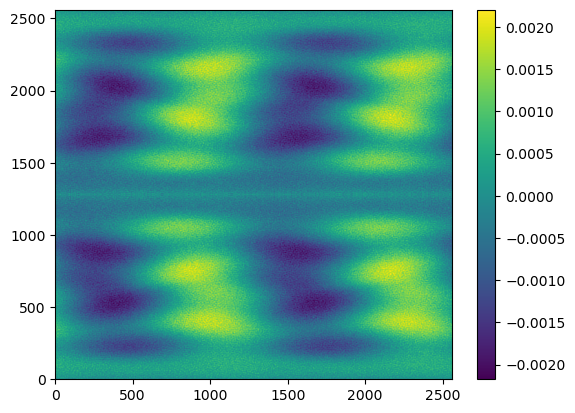

In [42]:
uk4, ufft4 = Euspec_prep(100)

In [ ]:
var_flip = np.flip(var, axis = 0)
var_per = np.concatenate((var, var_flip))

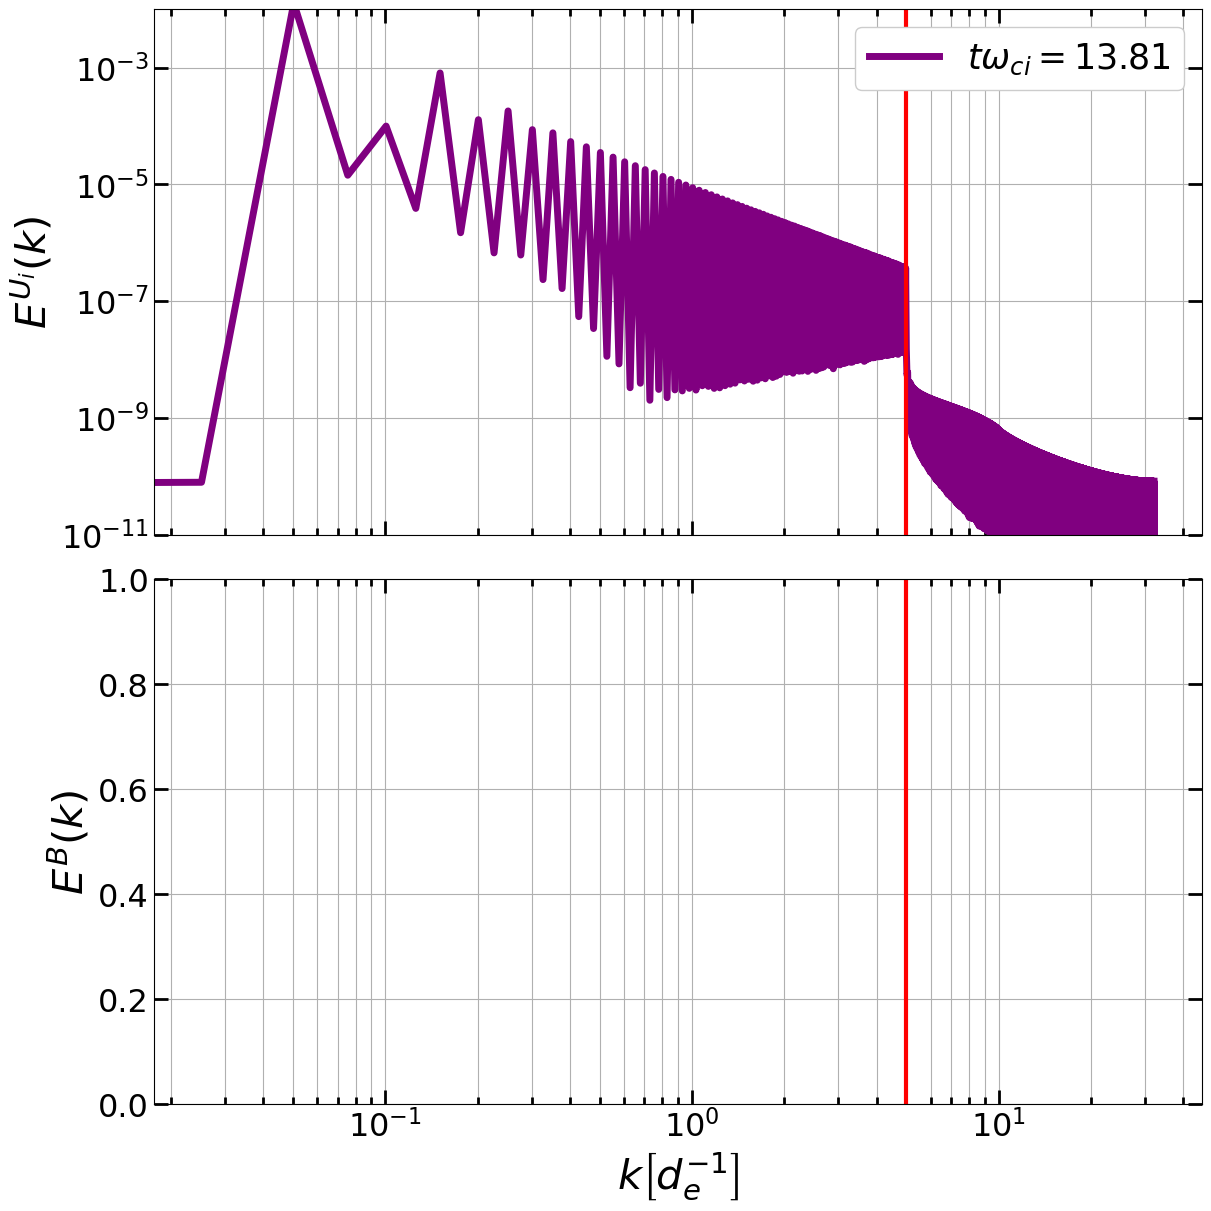

In [27]:
mpl.rcParams['lines.linewidth'] = 3

fig, ax1 = plt.subplots(2, 1, figsize = (12,12), sharex = True, layout = 'constrained')


# ax1[0].loglog(uk4[1:], ufft4[1:], color = 'purple' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
ax1[0].loglog(ku_1, Uktot_1, color = 'purple' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
ax1[0].axvline(5, color = 'red')
ax1[0].tick_params(which='both', width=2, labelsize = 23, right = True, direction = 'in')
ax1[0].tick_params(which='major', length=10, top = True, right =True)
ax1[0].tick_params(which='minor', length=5 , top = True, right =True)
ax1[0].set_ylim(1 * 10**(-11), 1 * 10**(-2))
ax1[0].set_ylabel(r'$E^{U_i} (k)$', size  = 30)
ax1[0].grid(which = 'both')
ax1[0].legend(loc = 'upper right', fontsize = 25, framealpha = 1)


# ax1[1].loglog(uk['k'][1:], uk['u0'][1:], color = 'purple' , label = r'$t \omega_{ci} =$'f'{np.round(twci[100] ,2)}' ,linewidth = 5)
# ax1[1].loglog(x1, y1, linewidth = 4, linestyle = '--', color = 'black')
# ax1[1].loglog(x3, y3, linewidth = 4, linestyle = '--', color = 'black')
ax1[1].axvline(5, color = 'red')
ax1[1].tick_params(which='both', width=2, labelsize = 23, right = True, direction = 'in')
ax1[1].tick_params(which='major', length=10, top = True, right =True)
ax1[1].tick_params(which='minor', length=5 , top = True, right =True)

# plt.text(x1[100], y1[100], r'$k^{-8/3}$', size = 30)
# plt.text(x3[100], y3[102], r'$k^{-4}$', size = 30)

ax1[1].set_ylabel(r'$E^B (k)$', size  = 30)
ax1[1].set_xlabel(r'$k  \left[ d_e^{-1}    \right]$', size = 30)
# ax1[1].set_xlim(1 * 10**(-2), 1 * 10**(1))
# ax1[1].set_ylim(1 * 10**(-7), 5 * 10**(-2))
ax1[1].grid(which = 'both')
# ax1[1].legend(loc = 'upper right', fontsize = 20)
# fig.savefig(figs + f'spectrum_twci.png', dpi = 150)